In [4]:
import numpy as np
import rasterio
from io import BytesIO
# import xarray as xr

import utils
from rasterio.windows import Window, get_data_window
from rasterio.transform import from_origin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
%load_ext autoreload

## Load Data

In [5]:
stacked_data = utils.rasterio_open('/Users/mayureshmuley/Desktop/Urban_hcf/data/LA_NDVI_SPH_2022_2023.tif')

In [6]:
stacked_data.data.shape

(10, 162, 146)

In [7]:
feature_names = stacked_data.bands

In [11]:
feature_names

('NDVI',
 'EVI',
 'sph',
 'pr',
 'impervious_descriptor',
 'landcover',
 'forecast_albedo',
 'built_height',
 'elevation',
 'LST_1KM')

In [10]:
X = stacked_data.data[:-1]          # (H, W)
y =stacked_data.data[-1,:,:]         # (num_features, H, W)

num_features, H, W = X.shape


In [11]:
num_features, H, W

(9, 162, 146)

## Create Windows  

In [12]:
def create_windows_with_coords(X, y, window_size=16, stride=16):
    X_windows, y_windows, coords = [], [], []

    for i in range(0, H - window_size + 1, stride):
        for j in range(0, W - window_size + 1, stride):

            x_patch = X[:, i:i+window_size, j:j+window_size]
            y_patch = y[i:i+window_size, j:j+window_size]

            if np.isnan(x_patch).any() or np.isnan(y_patch).any():
                continue

            x_feat = x_patch.reshape(num_features, -1).mean(axis=1)
            y_target = y_patch.mean()

            X_windows.append(x_feat)
            y_windows.append(y_target)
            coords.append((i, j))   # top-left pixel of window

    return np.array(X_windows), np.array(y_windows), np.array(coords)


In [13]:
X_win, y_win, coords = create_windows_with_coords(X, y, window_size=8, stride=4)

print(X_win.shape)  # (num_samples, num_features)
print(y_win.shape)


(930, 9)
(930,)


In [14]:
cols = coords[:, 1]  # j coordinate

left = np.percentile(cols, 70)
mid = np.percentile(cols, 85)

train_idx = cols <= left
val_idx = (cols > left) & (cols <= mid)
test_idx = cols > mid

X_train, y_train = X_win[train_idx], y_win[train_idx]
X_val, y_val     = X_win[val_idx], y_win[val_idx]
X_test, y_test   = X_win[test_idx], y_win[test_idx]

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (661, 9)
Val: (162, 9)
Test: (107, 9)


## Train Model

In [15]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [16]:
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=[4,5],
    # early_stopping_rounds=50,
    # verbose=50
)

/Users/mayureshmuley/Desktop/Urban_hcf/urbanhcf_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1555
[LightGBM] [Info] Number of data points in the train set: 661, number of used features: 9
[LightGBM] [Info] Start training from score 307.019416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/mayureshmuley/Desktop/Urban_hcf/urbanhcf_venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
              random_state=42, subsample=0.8)

## Evaluation

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

/Users/mayureshmuley/Desktop/Urban_hcf/urbanhcf_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [20]:
import pickle

filename = 'lst_model.pkl'
# Save the model
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [25]:
with open("lst_model.pkl", "rb") as f:
    model = pickle.load(f)

# Save as LightGBM native format
model.booster_.save_model("lst_model.txt")

In [18]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f} K")
print(f"MAE:  {mae:.2f} K")
print(f"R²:   {r2:.3f}")


RMSE: 1.77 K
MAE:  1.41 K
R²:   0.897


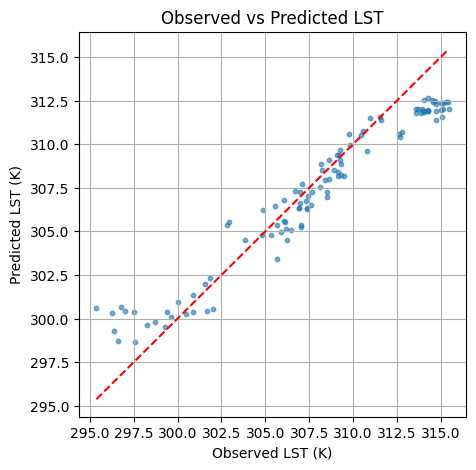

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=10, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Observed LST (K)")
plt.ylabel("Predicted LST (K)")
plt.title("Observed vs Predicted LST")
plt.grid(True)
plt.show()


/Users/mayureshmuley/Desktop/Urban_hcf/urbanhcf_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


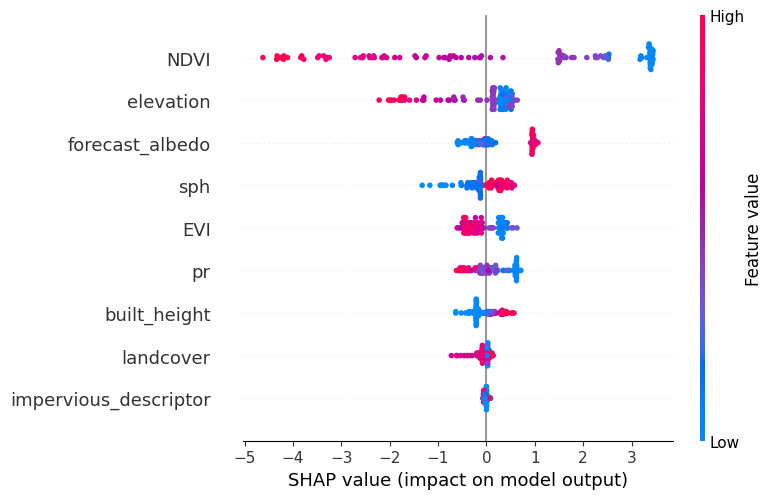

In [20]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)


In [22]:
import pandas as pd

feature_names = feature_names  # list of your features
importances = model.feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_names[:-1],
    "importance": importances
}).sort_values("importance", ascending=False)

print(imp_df)


                 feature  importance
6        forecast_albedo        1992
2                    sph        1894
3                     pr        1824
0                   NDVI        1770
1                    EVI        1762
8              elevation        1670
7           built_height        1120
5              landcover         323
4  impervious_descriptor         114


In [23]:
import numpy as np

mean_lst = np.nanmean(y_pred)
uhi_map = y_pred - mean_lst


In [27]:
uhi_map.shape

(107,)

In [24]:
stacked_data.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 146, 'height': 162, 'count': 10, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.008983152841195215, 0.0, -118.95490992310704,
       0.0, -0.008983152841195215, 34.85463302383744), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

In [31]:
crs = "EPSG:3857"  # Example CRS
output_path = "test_preds_new.tif"
transform = stacked_data.profile['transform']

## Inference

In [69]:
import numpy as np
X = stacked_data.data[:-1,:,:] 
X.shape


(9, 162, 146)

In [71]:
X_feat = X.reshape(num_features, -1).T  # (H*W, num_features)
y_label = y.flatten()

In [72]:
y_label.shape, X_feat.shape

((23652,), (23652, 9))

In [73]:
X_win.shape

(930, 9)

In [74]:
La_pred = model.predict(X_feat)

/Users/mayureshmuley/Desktop/Urban_hcf/urbanhcf_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [77]:
La_pred.shape

(23652,)

In [80]:
# shape = X_test.shape
La_pred = La_pred.reshape(H, W)

In [79]:
pred_array.shape

(162, 146)

In [81]:
La_pred.shape

(162, 146)

In [46]:
profile = stacked_data.profile

In [82]:
with rasterio.open(
    output_path,
    "w",
    driver="GTiff",
    height=H,
    width=W,
    count=1,  # Single band
    dtype=La_pred.dtype,
    crs=profile['crs'],
    transform=profile['transform'],
) as dst:
    dst.write(La_pred, 1)

In [24]:
import lightgbm
print(lightgbm.__version__)

4.5.0
